In [1]:
import pandas as pd
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import export_graphviz
import graphviz
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import *
from sklearn.utils import resample
from tqdm import tqdm
import numpy as np
from Bio import SeqIO
from Bio.Seq import Seq
from Bio.SeqUtils import gc_fraction
from Bio import SeqIO
from collections import Counter

In [11]:
NFS13 = "C:/Users/User/Desktop/USP/Projeto/Hits/NFS13.fasta"
gc_data = []
comprimento = []

# Calcular o conteúdo de GC
for record in SeqIO.parse(NFS13, "fasta"):
    gc_content = gc_fraction(record.seq) * 100  # Calcular GC e converter para %
    gc = round(gc_content, 2)  # Arredondar
    length = len(record.seq)
    gc_data.append({"Node": record.id, "GC_Content": gc, "Length": length})

# Criar um DataFrame
gc_df = pd.DataFrame(gc_data)

#gc_df.to_csv("gc_content.csv", index=False)

# Visualizar os primeiros resultados
print(gc_df.head())

                                 Node  GC_Content  Length
0   NODE_1_length_7560_cov_172.020179       41.20    7560
1   NODE_2_length_7385_cov_352.574849       56.18    7385
2  NODE_3_length_6817_cov_1229.048516       37.83    6817
3    NODE_4_length_5944_cov_80.250724       54.85    5944
4     NODE_5_length_5739_cov_5.438008       61.27    5739


In [3]:
def calc_tetranucleotide_frequency(sequence):
    # Gerar tetranucleotídeos
    tetranucleotides = [sequence[i:i+4] for i in range(len(sequence) - 3)]
    # Filtrar apenas os válidos
    valid_tetranucleotides = [tet for tet in tetranucleotides if set(tet).issubset({"A", "C", "G", "T"})]
    # Contar as frequências
    counts = Counter(valid_tetranucleotides)
    # Normalizar as frequências
    total = sum(counts.values())
    if total > 0:
        normalized_counts = {k: v / total for k, v in counts.items()}
    else:
        normalized_counts = 0
    return normalized_counts

In [4]:
FTN = []
for record in SeqIO.parse(NFS13, "fasta"):
    freq_dict = calc_tetranucleotide_frequency(record.seq)
    freq_dict["Node"] = record.id  # Adicionar o Accession como chave
    FTN.append(freq_dict)

In [5]:
tetranuc_df = pd.DataFrame(FTN)

In [6]:
tetranuc_df

,"(A, T, A, G)","(T, A, G, A)","(A, G, A, A)","(G, A, A, T)","(A, A, T, C)","(A, T, C, C)","(T, C, C, C)","(C, C, C, T)","(C, C, T, T)","(C, T, T, T)",...,"(G, G, T, C)","(C, G, G, T)","(C, G, G, G)","(G, T, C, C)","(G, C, G, T)","(C, G, A, C)","(C, G, C, G)","(T, C, G, A)","(A, C, G, A)",Node
0,0.006881,0.006087,0.011116,0.007278,0.005690,0.004896,0.002250,0.004102,0.005558,0.007146,...,0.000794,0.001323,0.000529,0.000529,0.001456,0.000265,0.000662,0.000265,0.001588,NODE_1_length_7560_cov_172.020179
1,0.000813,0.000813,0.002980,0.004606,0.003387,0.005690,0.002980,0.001355,0.002980,0.003658,...,0.004064,0.005554,0.004335,0.002709,0.006367,0.005283,0.009753,0.007586,0.005825,NODE_2_length_7385_cov_352.574849
2,0.003082,0.001908,0.005577,0.005870,0.008072,0.006457,0.005577,0.003082,0.005724,0.009686,...,0.001468,0.001468,0.000440,0.003522,0.000881,0.000440,0.000294,0.001027,0.001468,NODE_3_length_6817_cov_1229.048516
3,0.002020,0.001010,0.004713,0.004376,0.006228,0.004208,0.003535,0.001178,0.003030,0.003366,...,0.004376,0.005050,0.004713,0.003198,0.004208,0.005723,0.009426,0.008753,0.004881,NODE_4_length_5944_cov_80.250724
4,0.000872,0.000174,0.001743,0.003312,0.003661,0.004707,0.002615,0.002266,0.002615,0.002964,...,0.005404,0.005404,0.008543,0.003661,0.006102,0.007845,0.011332,0.009414,0.005404,NODE_5_length_5739_cov_5.438008
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2329,0.004016,0.002008,0.004016,0.006024,0.008032,0.006024,0.010040,0.004016,0.004016,0.006024,...,0.008032,0.006024,0.006024,0.004016,0.012048,0.010040,0.026104,0.012048,0.008032,NODE_2330_length_501_cov_4.089623
2330,0.002008,NaN,NaN,0.002008,NaN,0.004016,0.004016,0.002008,NaN,NaN,...,0.004016,0.006024,0.006024,0.004016,0.006024,0.014056,0.014056,0.006024,0.004016,NODE_2331_length_501_cov_3.400943
2331,NaN,NaN,0.002008,NaN,0.004016,0.012048,0.006024,NaN,0.002008,NaN,...,0.010040,0.004016,0.004016,0.004016,0.002008,0.016064,0.008032,0.004016,0.006024,NODE_2332_length_501_cov_2.448113
2332,0.010040,0.010040,0.010040,NaN,0.004016,0.004016,0.002008,0.004016,0.004016,0.004016,...,NaN,NaN,NaN,0.002008,NaN,NaN,NaN,0.002008,NaN,NODE_2333_length_501_cov_2.325472


In [7]:
colunas = [
    "Query_ID", "Domain", "Length", "HMM_ID", "HMM_Accession", "HMM_Length", 
    "Full_E-Value", "Full_Score", "Full_Bias", "Domain_Num", "Total_Domains", 
    "Domain_C-Evalue", "Domain_I-Evalue", "Domain_Score", "Domain_Bias", 
    "HMM_From", "HMM_To", "Ali_From", "Ali_To", "Env_From", "Env_To", "Accuracy", "-"
]
NFS13_pfam = pd.read_csv("C:/Users/User/Desktop/USP/Projeto/Hits/hits_pfam_NFS13.txt", delim_whitespace=True, names=colunas)
NFS13_pfam.head(5)

,Query_ID,Domain,Length,HMM_ID,HMM_Accession,HMM_Length,Full_E-Value,Full_Score,Full_Bias,Domain_Num,...,Domain_Score,Domain_Bias,HMM_From,HMM_To,Ali_From,Ali_To,Env_From,Env_To,Accuracy,-
0,NODE_5_length_5739_cov_5.438008,-,1913,2-Hacid_dh,PF00389.33,134,2.700000e-17,59.8,0.0,1,...,59.2,0.0,30,134,941,1222,915,1222,0.96,-
1,NODE_5_length_5739_cov_5.438008,-,1913,2-Hacid_dh_C,PF02826.22,178,6.300000e-53,175.9,0.0,1,...,174.6,0.0,2,177,1020,1189,1015,1190,0.89,-
2,NODE_5_length_5739_cov_5.438008,-,1913,2-Hacid_dh_C,PF02826.22,178,6.300000e-53,175.9,0.0,2,...,-3.4,0.0,111,135,1513,1537,1512,1538,0.86,-
3,NODE_732_length_880_cov_2.403487,-,294,2-Hacid_dh_C,PF02826.22,178,7.800000e-13,45.3,0.0,1,...,44.7,0.0,23,102,167,241,144,244,0.81,-
4,NODE_2316_length_503_cov_1.941315,-,168,2-Hacid_dh_C,PF02826.22,178,8.600000e-08,28.8,0.2,1,...,28.5,0.2,1,67,104,167,104,168,0.94,-


In [8]:
df_aggregated = NFS13_pfam.groupby(["Query_ID", "HMM_ID"], as_index=False)["Full_Score"].max()
df_aggregated

,Query_ID,HMM_ID,Full_Score
0,NODE_1002_length_768_cov_24.192475,Usg,62.4
1,NODE_1022_length_762_cov_1.385401,COesterase,33.6
2,NODE_102_length_1931_cov_10.360841,AAA_21,51.3
3,NODE_102_length_1931_cov_10.360841,ABC_tran,99.2
4,NODE_1037_length_759_cov_4.011730,Porin_2,73.7
...,...,...,...
439,NODE_959_length_784_cov_3.326733,TOBE_2,49.1
440,NODE_96_length_1983_cov_4.846275,FAD_oxidored,164.1
441,NODE_972_length_778_cov_5.496434,ApbA_C,31.9
442,NODE_981_length_775_cov_1.272206,Porin_2,53.2


In [17]:
matriz_hmm = df_aggregated.pivot(index="Query_ID", columns="HMM_ID", values="Full_Score")

# Substituir valores NaN por 0
matriz_hmm.fillna(0, inplace=True)

# Visualizar as primeiras linhas da matriz
print(matriz_hmm.head())

HMM_ID                              2-Hacid_dh  2-Hacid_dh_C  3-dmu-9_3-mt  \
Query_ID                                                                     
NODE_1002_length_768_cov_24.192475         0.0           0.0           0.0   
NODE_1022_length_762_cov_1.385401          0.0           0.0           0.0   
NODE_102_length_1931_cov_10.360841         0.0           0.0           0.0   
NODE_1037_length_759_cov_4.011730          0.0           0.0           0.0   
NODE_103_length_1930_cov_6.178629          0.0           0.0           0.0   

HMM_ID                              4HBT  4HBT_2  4HB_MCP_1  AAA_21  AAA_22  \
Query_ID                                                                      
NODE_1002_length_768_cov_24.192475   0.0     0.0        0.0     0.0     0.0   
NODE_1022_length_762_cov_1.385401    0.0     0.0        0.0     0.0     0.0   
NODE_102_length_1931_cov_10.360841   0.0     0.0        0.0    51.3     0.0   
NODE_1037_length_759_cov_4.011730    0.0     0.0        0.

In [20]:
matriz_hmm.reset_index(inplace=True)

In [18]:
NFS13 = pd.merge(gc_df, tetranuc_df, on="Node")
print(NFS13.head())

                                 Node  GC_Content  Length  (A, T, A, G)  \
0   NODE_1_length_7560_cov_172.020179       41.20    7560      0.006881   
1   NODE_2_length_7385_cov_352.574849       56.18    7385      0.000813   
2  NODE_3_length_6817_cov_1229.048516       37.83    6817      0.003082   
3    NODE_4_length_5944_cov_80.250724       54.85    5944      0.002020   
4     NODE_5_length_5739_cov_5.438008       61.27    5739      0.000872   

   (T, A, G, A)  (A, G, A, A)  (G, A, A, T)  (A, A, T, C)  (A, T, C, C)  \
0      0.006087      0.011116      0.007278      0.005690      0.004896   
1      0.000813      0.002980      0.004606      0.003387      0.005690   
2      0.001908      0.005577      0.005870      0.008072      0.006457   
3      0.001010      0.004713      0.004376      0.006228      0.004208   
4      0.000174      0.001743      0.003312      0.003661      0.004707   

   (T, C, C, C)  ...  (G, C, G, A)  (G, G, T, C)  (C, G, G, T)  (C, G, G, G)  \
0      0.002250  .

In [21]:
NFS13_DarkMatter = pd.merge(NFS13, matriz_hmm, left_on="Node", right_on="Query_ID", how="inner")
NFS13_DarkMatter.head()
NFS13_DarkMatter.to_csv("C:/Users/User/Desktop/USP/Projeto/sheets/NFS13_all.csv")

In [2]:
df = pd.read_csv("C:/Users/User/Desktop/USP/Projeto/sheets/Metadata_Familia.csv")

In [3]:
colunas_remover = ["Unnamed: 0"]
df = df.drop(columns = colunas_remover)
df = df.dropna()

In [4]:
df.head()

,Family,Length,GC_Content,AACA,ACAT,CATC,ATCC,TCCA,CCAC,CACC,...,Zn-ribbon_8,cREC_REC,dCMP_cyt_deam_1,dUTPase,gp12-short_mid,gp32,gp37_C,gp45-slide_C,motB,zf-dskA_traR
0,Anelloviridae,3154,51.43,0.008251,0.004760,0.002222,0.001904,0.004443,0.008886,0.008886,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Picornaviridae,7137,40.24,0.010653,0.006308,0.003224,0.002523,0.005607,0.004626,0.003925,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Picornaviridae,7424,46.90,0.006468,0.005794,0.004986,0.004043,0.004582,0.006199,0.005660,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Anelloviridae,2884,36.82,0.013537,0.007636,0.003471,0.002777,0.002430,0.007289,0.004859,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Pneumoviridae,15184,33.40,0.013178,0.007643,0.005337,0.004876,0.004217,0.003229,0.002701,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


<Axes: xlabel='Family', ylabel='count'>

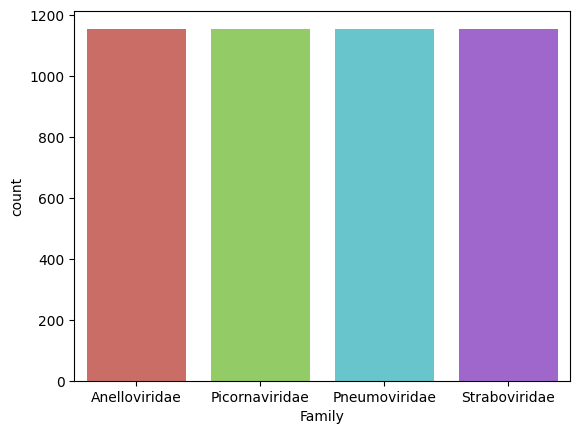

In [5]:
import seaborn as sns
sns.countplot(data=df, x = 'Family', hue = 'Family', palette="hls")

In [6]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Separando as features (X) e o rótulo (y)
X = df.drop(columns=['Family'])
y = df['Family']

# Convertendo rótulos categóricos para numéricos
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Dividindo os dados em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [7]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(max_depth = 3, min_samples_leaf = 1, min_samples_split = 2, n_estimators = 100, max_features = "sqrt", random_state =  42)
rf.fit(X_train, y_train)

RandomForestClassifier(max_depth=3, random_state=42)

In [10]:
import pickle
model_pkl_file = "RandomForestModel.pkl"  

with open(model_pkl_file, 'wb') as file:  
    pickle.dump(rf, file)

In [46]:
from xgboost import XGBClassifier

xgb = XGBClassifier(eval_metric='logloss', random_state = 42)
y_train_encoded = label_encoder.fit_transform(y_train)
xgb.fit(X_train, y_train_encoded)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, objective='multi:softprob', ...)

In [14]:
NFS13 = pd.read_csv("C:/Users/User/Desktop/USP/Projeto/sheets/NFS13_all.csv")

In [15]:
features = X_train.columns
features

Index(['Length', 'GC_Content', 'AACA', 'ACAT', 'CATC', 'ATCC', 'TCCA', 'CCAC',
       'CACC', 'ACCG',
       ...
       'Zn-ribbon_8', 'cREC_REC', 'dCMP_cyt_deam_1', 'dUTPase',
       'gp12-short_mid', 'gp32', 'gp37_C', 'gp45-slide_C', 'motB',
       'zf-dskA_traR'],
      dtype='object', length=555)

In [16]:
# Identificar as colunas que estão faltando no DataFrame
missing_cols = [col for col in features if col not in NFS13.columns]

# Criar um DataFrame com as colunas ausentes preenchidas com 0
missing_df = pd.DataFrame(0, index=NFS13.index, columns=missing_cols)

# Concatenar o DataFrame original com o DataFrame de colunas ausentes
NFS13_test = pd.concat([NFS13, missing_df], axis=1)

# Garantir que as colunas estejam na mesma ordem das usadas no modelo
NFS13_test = NFS13_test[features]

In [17]:
NFS13_test = NFS13_test.fillna(0)
NFS13_test.head()

,Length,GC_Content,AACA,ACAT,CATC,ATCC,TCCA,CCAC,CACC,ACCG,...,Zn-ribbon_8,cREC_REC,dCMP_cyt_deam_1,dUTPase,gp12-short_mid,gp32,gp37_C,gp45-slide_C,motB,zf-dskA_traR
0,7560,41.20,0.004234,0.002779,0.001456,0.004896,0.003970,0.002911,0.001853,0.002911,...,0,0,0,0,0,0,0,0,0,0
1,7385,56.18,0.001761,0.003251,0.005283,0.005690,0.002980,0.003251,0.002709,0.002980,...,0,0,0,0,0,0,0,0,0,0
2,6817,37.83,0.006017,0.005577,0.006017,0.006457,0.008659,0.003669,0.003375,0.001761,...,0,0,0,0,0,0,0,0,0,0
3,5944,54.85,0.003703,0.002861,0.006565,0.004208,0.004040,0.001178,0.002188,0.004040,...,0,0,0,0,0,0,0,0,0,0
4,5739,61.27,0.001220,0.002266,0.005753,0.004707,0.002964,0.003138,0.001918,0.004533,...,0,0,0,0,0,0,0,0,0,0


In [18]:
# Selecionar as colunas de interesse (258 até 1069)
pfam = NFS13_test.columns[258:554]  # 1070 é exclusivo, então inclui 1069

# Criar uma máscara para linhas onde todas as colunas selecionadas são zero
mascara = (NFS13_test[pfam] == 0).all(axis=1)

# Remover as linhas onde a máscara é True
NFS13_test_final = NFS13_test.loc[~mascara]

print(f"Linhas antes: {NFS13_test.shape[0]}")
print(f"Linhas depois: {NFS13_test_final.shape[0]}")

Linhas antes: 301
Linhas depois: 21


In [23]:
print(list(pfam))

['5_3_exonuc_N', 'AAA', 'AAA_14', 'AAA_16', 'AAA_18', 'AAA_19', 'AAA_22', 'AAA_23', 'AAA_25', 'AAA_28', 'AAA_29', 'AAA_30', 'AAA_33', 'ABC_tran', 'ADP_ribosyl_GH', 'ADPrib_exo_Tox', 'AGT', 'ALC', 'AP2', 'ATP-cone', 'Acid_phosphat_B', 'AsiA', 'Band_7', 'Beta_elim_lyase', 'CAV_VP3', 'CLP_protease', 'CM_2', 'CTP_transf_like', 'Calici_coat', 'Caudo_TAP', 'Collagen', 'Collar', 'Cpn10', 'DAHP_synth_1', 'DAO', 'DEAD', 'DHFR_1', 'DNA_PPF', 'DNA_Packaging', 'DNA_gyraseB', 'DNA_ligase_A_M', 'DNA_ligase_OB_2', 'DNA_methylase', 'DNA_pol3_delta2', 'DNA_pol_B', 'DNA_pol_B_exo1', 'DNA_topoisoIV', 'DUF1190', 'DUF262', 'DUF2654', 'DUF2685', 'DUF2774', 'DUF2828', 'DUF2829', 'DUF2883', 'DUF3045', 'DUF3307', 'DUF3383', 'DUF3724', 'DUF4031', 'DUF4055', 'DUF4326', 'DUF5417', 'DUF5481', 'DUF5484', 'DUF5486', 'DUF5487', 'DUF5490', 'DUF5491', 'DUF5495', 'DUF5496', 'DUF5498', 'DUF5499', 'DUF5856', 'DUF755', 'Dmd', 'DnaB_C', 'DnaJ', 'DnaT_2', 'Endonuc-dimeris', 'Endonuclease_7', 'FRD2', 'Fer4_12', 'Fer4_14', 'Fi

In [17]:
NFS13_test_final.columns

Index(['Length', 'GC_Content', 'AACA', 'ACAT', 'CATC', 'ATCC', 'TCCA', 'CCAC',
       'CACC', 'ACCG',
       ...
       'Zn-ribbon_8', 'cREC_REC', 'dCMP_cyt_deam_1', 'dUTPase',
       'gp12-short_mid', 'gp32', 'gp37_C', 'gp45-slide_C', 'motB',
       'zf-dskA_traR'],
      dtype='object', length=555)

In [10]:
predicoes = rf.predict(NFS13)

# Opcional: adicionar as previsões ao novo dataset
NFS13["Predicoes"] = predicoes

# Exibir as primeiras linhas para verificar
print(NFS13.head())

   Length  GC_Content      AACA      ACAT      CATC      ATCC      TCCA  \
0    7560       41.20  0.004234  0.002779  0.001456  0.004896  0.003970   
1    7385       56.18  0.001761  0.003251  0.005283  0.005690  0.002980   
2    6817       37.83  0.006017  0.005577  0.006017  0.006457  0.008659   
3    5944       54.85  0.003703  0.002861  0.006565  0.004208  0.004040   
4    5739       61.27  0.001220  0.002266  0.005753  0.004707  0.002964   

       CCAC      CACC      ACCG  ...  cREC_REC  dCMP_cyt_deam_1  dUTPase  \
0  0.002911  0.001853  0.002911  ...         0                0        0   
1  0.003251  0.002709  0.002980  ...         0                0        0   
2  0.003669  0.003375  0.001761  ...         0                0        0   
3  0.001178  0.002188  0.004040  ...         0                0        0   
4  0.003138  0.001918  0.004533  ...         0                0        0   

   gp12-short_mid  gp32  gp37_C  gp45-slide_C  motB  zf-dskA_traR  \
0               0     0

In [18]:
Predict_RF = rf.predict(NFS13_test_final)

NFS13_test_final["Predições_RF"] = Predict_RF

C:\Users\User\AppData\Local\Temp\ipykernel_6636\1950475674.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  NFS13_test_final["Predições_RF"] = Predict_RF


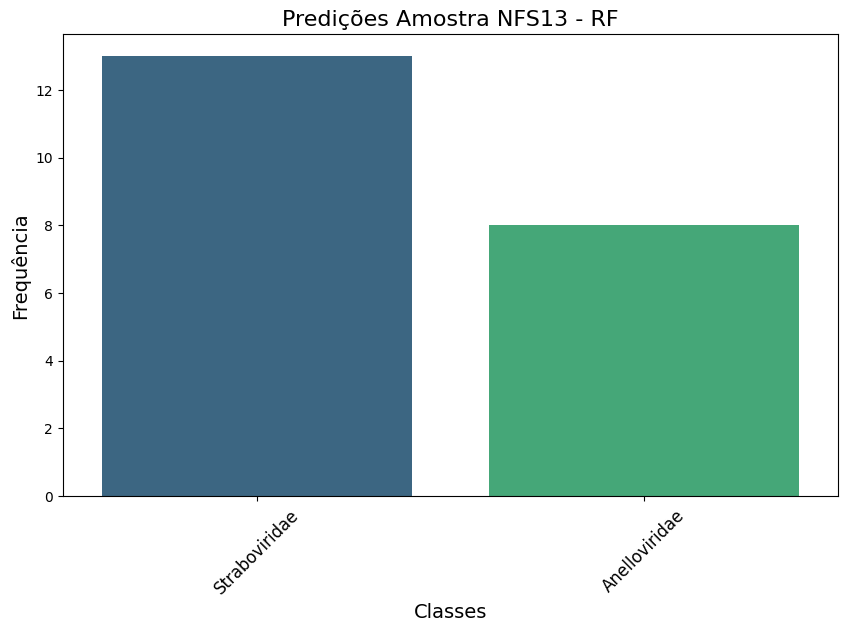

In [19]:
df_plot = NFS13_test_final["Predições_RF"].value_counts().reset_index()
df_plot.columns = ["Classe", "Frequência"]

# Plotar o gráfico
plt.figure(figsize=(10, 6))
sns.barplot(data=df_plot, x="Classe", y="Frequência", palette="viridis", hue = "Classe")
plt.title("Predições Amostra NFS13 - RF", fontsize=16)
plt.xlabel("Classes", fontsize=14)
plt.ylabel("Frequência", fontsize=14)
plt.xticks(rotation=45, fontsize=12)
plt.show()

In [41]:
linhas_restantes

RangeIndex(start=0, stop=301, step=1)

In [42]:
linhas_restantes = NFS13_test_final.index
ids = NFS13.loc[linhas_restantes, 'Node']


# Criar o DataFrame com as previsões e as classes originais
resultados = pd.DataFrame({
    'Node': ids,
    'RF': Predict_RF
})


print(resultados)

                                   Node             RF
15    NODE_29_length_3085_cov_10.385971  Anelloviridae
24     NODE_57_length_2517_cov_5.754098  Anelloviridae
33   NODE_102_length_1931_cov_10.360841  Straboviridae
36    NODE_105_length_1915_cov_9.515778  Straboviridae
72   NODE_297_length_1271_cov_14.748744  Straboviridae
92   NODE_433_length_1101_cov_15.849609  Straboviridae
99    NODE_496_length_1029_cov_2.904412  Straboviridae
100  NODE_501_length_1025_cov_16.699367  Anelloviridae
115    NODE_586_length_967_cov_8.198876  Anelloviridae
147   NODE_772_length_861_cov_33.250000  Straboviridae
172   NODE_991_length_771_cov_10.456772  Anelloviridae
177   NODE_1074_length_748_cov_2.955291  Anelloviridae
186  NODE_1110_length_735_cov_39.597264  Straboviridae
207  NODE_1251_length_695_cov_12.053398  Anelloviridae
218   NODE_1341_length_673_cov_5.119128  Straboviridae
221   NODE_1373_length_665_cov_2.091837  Anelloviridae
226   NODE_1420_length_651_cov_8.764808  Straboviridae
244   NODE

In [47]:
NFS13_test_final.drop("Predições_RF", axis=1, inplace=True)
Predict_XGB = xgb.predict(NFS13_test_final)

NFS13_test_final["Predições_XGB"] = Predict_XGB

C:\Users\User\AppData\Local\Temp\ipykernel_6636\609110911.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_plot, x="Classe", y="Frequência", palette="viridis")


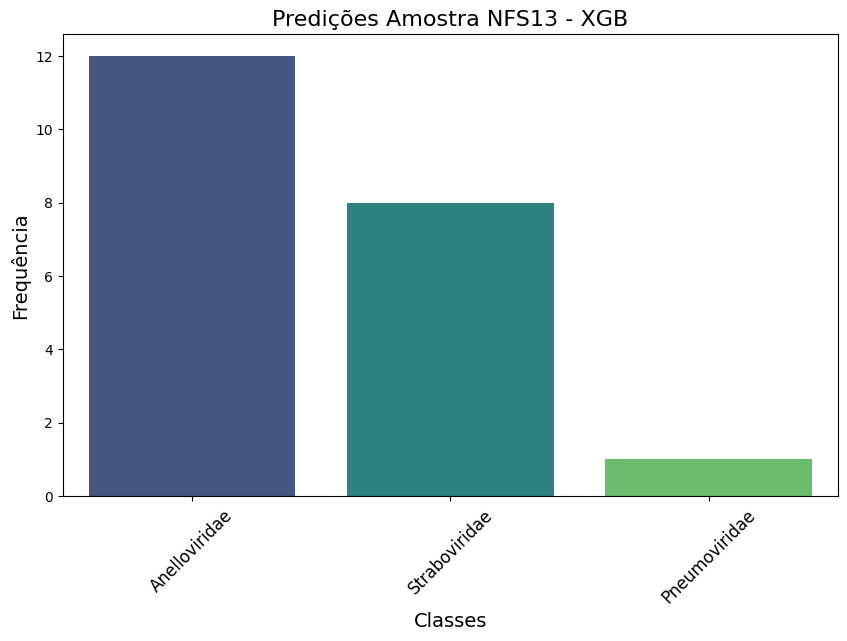

In [48]:
df_plot = NFS13_test_final["Predições_XGB"].value_counts().reset_index()
df_plot.columns = ["Classe", "Frequência"]
df_plot["Classe"] = label_encoder.inverse_transform(df_plot["Classe"])

# Plotar o gráfico com os nomes das classes
plt.figure(figsize=(10, 6))
sns.barplot(data=df_plot, x="Classe", y="Frequência", palette="viridis")
plt.title("Predições Amostra NFS13 - XGB", fontsize=16)
plt.xlabel("Classes", fontsize=14)
plt.ylabel("Frequência", fontsize=14)
plt.xticks(rotation=45, fontsize=12)
plt.show()

In [49]:
linhas_restantes = NFS13_test_final.index
ids = NFS13.loc[linhas_restantes, 'Node']


resultados = pd.DataFrame({
    'Node': ids,
    'XGB': label_encoder.inverse_transform(Predict_XGB)
})

print(resultados)

                                   Node            XGB
15    NODE_29_length_3085_cov_10.385971  Anelloviridae
24     NODE_57_length_2517_cov_5.754098  Anelloviridae
33   NODE_102_length_1931_cov_10.360841  Straboviridae
36    NODE_105_length_1915_cov_9.515778  Anelloviridae
72   NODE_297_length_1271_cov_14.748744  Anelloviridae
92   NODE_433_length_1101_cov_15.849609  Straboviridae
99    NODE_496_length_1029_cov_2.904412  Straboviridae
100  NODE_501_length_1025_cov_16.699367  Anelloviridae
115    NODE_586_length_967_cov_8.198876  Pneumoviridae
147   NODE_772_length_861_cov_33.250000  Straboviridae
172   NODE_991_length_771_cov_10.456772  Anelloviridae
177   NODE_1074_length_748_cov_2.955291  Anelloviridae
186  NODE_1110_length_735_cov_39.597264  Anelloviridae
207  NODE_1251_length_695_cov_12.053398  Straboviridae
218   NODE_1341_length_673_cov_5.119128  Straboviridae
221   NODE_1373_length_665_cov_2.091837  Anelloviridae
226   NODE_1420_length_651_cov_8.764808  Anelloviridae
244   NODE